In [1]:
import tensorflow as tf

2023-08-22 16:55:04.341685: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-22 16:55:04.370987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 16:55:05.478935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.13.0'

In [3]:
import glob
# import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
# from tensorflow.python.keras import layers
from tensorflow.keras import layers, activations
import time
import nibabel as nib
from tqdm import tqdm
import gc
from scipy.ndimage import binary_erosion
from IPython import display
import datetime

import model

In [4]:
subjects = [ f.name for f in os.scandir('./Data') if f.is_dir() and f.name != '.ipynb_checkpoints']

# subjects = ['390645', '120111']

e_or_o = 1

p_size_i = 7
p_size_o = 4

print(subjects)

['390645', '545345', '106016', '120111', '101915', '351938', '705341']


In [5]:
subjects_lr = []
subjects_hr = []
subjects_masks = []

subjects_preproc_values_lr = []
subjects_preproc_values_hr = []

subjects_preproc_values_h4_lr = []
subjects_preproc_values_h4_hr = []

subjects_t1_preproc_values = []

for subj in subjects:

    h4_imgs = []
    h4_imgs_lr = []
    dti_imgs = []
    dti_imgs_lr = []

    # DTI normalisation metrics pre-normalisation (storing max and min values in the mask) - Store for HR only
    dti_preprocs_hr = np.zeros((6,2))
    dti_preprocs_lr = np.zeros((6,2))

    h4_preprocs_hr = np.zeros((22,2))
    h4_preprocs_lr = np.zeros((22,2))

    print("Loading Subject {}".format(subj))
    
    for i in range(1,9):
    
        dti_data = np.array(nib.load("Data/{}/T1w/Diffusion/dt_all_{}.nii".format(subj,i)).get_fdata())
        dti_data_lr = np.array(nib.load("Data/{}/T1w/Diffusion/dt_all_lowres_2_{}.nii".format(subj,i)).get_fdata())
    
        # if i > 1:
        #     dti_data[dti_imgs[0] < 0] = 0
        #     dti_data_lr[dti_imgs[0] < 0] = 0
    
        dti_imgs.append(dti_data)
        dti_imgs_lr.append(dti_data_lr)
    
        dti_data = None
        dti_data_lr = None
    
    for i in range(1,25):
    
        h4_data = np.array(nib.load("Data/{}/T1w/Diffusion/h4_all_{}.nii".format(subj,str(i).zfill(2))).get_fdata())
        h4_data_lr = np.array(nib.load("Data/{}/T1w/Diffusion/h4_all_lowres_2_{}.nii".format(subj,str(i).zfill(2))).get_fdata())
    
        # if i > 1:
        #     h4_data[h4_data[0] < 0] = 0
        #     h4_data_lr[h4_data[0] < 0] = 0
        
        h4_imgs.append(h4_data)
        h4_imgs_lr.append(h4_data_lr)
    
        h4_data = None
        h4_data_lr = None
    
    h4_imgs = np.array(h4_imgs).transpose((1,2,3,0))
    h4_imgs_lr = np.array(h4_imgs_lr).transpose((1,2,3,0))
    
    dti_imgs = np.array(dti_imgs).transpose((1,2,3,0))
    dti_imgs_lr = np.array(dti_imgs_lr).transpose((1,2,3,0))
    
    mask = h4_imgs[...,0]

    binmask = np.zeros(mask.shape)

    binmask[mask >= 0] = 1

    mask = binary_erosion(binmask, structure=np.ones((5,5,5),np.uint8),iterations = 1)

    binmask = None

    # Calculate DTI ranges and normalise to range [0,1]
    for i in range(2,8):

        dti_preprocs_lr[i-2,:] = np.array([np.min(mask*dti_imgs_lr[...,i]), np.max(mask*dti_imgs_lr[...,i])])
        dti_imgs_lr[mask>0, i] = (dti_imgs_lr[mask>0, i] - dti_preprocs_lr[i-2,0] + 0.0001) / (dti_preprocs_lr[i-2,1] - dti_preprocs_lr[i-2,0])
        dti_imgs_lr[mask==0, i] = 0

        dti_preprocs_hr[i-2,:] = np.array([np.min(mask*dti_imgs[...,i]), np.max(mask*dti_imgs[...,i])])
        dti_imgs[mask>0, i] = (dti_imgs[mask>0, i] - dti_preprocs_hr[i-2,0] + 0.0001) / (dti_preprocs_hr[i-2,1] - dti_preprocs_hr[i-2,0])
        dti_imgs[mask==0, i] = 0


    # Calculate H4 ranges and normalise to range [0,1]
    for i in range(2,24):

        h4_preprocs_lr[i-2,:] = np.array([np.min(mask*h4_imgs_lr[...,i]), np.max(mask*h4_imgs_lr[...,i])])
        h4_imgs_lr[mask>0, i] = (h4_imgs_lr[mask>0, i] - h4_preprocs_lr[i-2,0] + 0.0001) / (h4_preprocs_lr[i-2,1] - h4_preprocs_lr[i-2,0])
        h4_imgs_lr[mask==0, i] = 0

        h4_preprocs_hr[i-2,:] = np.array([np.min(mask*h4_imgs[...,i]), np.max(mask*h4_imgs[...,i])])
        h4_imgs[mask>0, i] = (h4_imgs[mask>0, i] - h4_preprocs_hr[i-2,0] + 0.0001) / (h4_preprocs_hr[i-2,1] - h4_preprocs_hr[i-2,0])
        h4_imgs[mask==0, i] = 0


    t1w = nib.load("Data/{}/T1w/Diffusion/t1w.nii".format(subj))
    
    t1w_data = np.array(t1w.get_fdata())
    
    t1w_data_format = np.concatenate(
        (t1w_data[::2,::2,::2, None], t1w_data[::2,::2,1::2, None],
         t1w_data[::2,1::2,::2, None], t1w_data[::2,1::2,1::2, None],
         t1w_data[1::2,::2,::2, None], t1w_data[1::2,::2,1::2, None],
         t1w_data[1::2,1::2,::2, None], t1w_data[1::2,1::2,1::2, None]),
        axis=-1)

    t1w_preprocs = np.array([np.min(t1w_data_format*mask[...,None]), np.max(t1w_data_format*mask[...,None])])
    
    subjects_t1_preproc_values.append(t1w_preprocs)    
    t1w_data_format[mask>0, :] = (t1w_data_format[mask>0, :] - t1w_preprocs[0] + 0.0001) / (t1w_preprocs[1] - t1w_preprocs[0])

    subjects_preproc_values_lr.append(dti_preprocs_lr)
    subjects_preproc_values_hr.append(dti_preprocs_hr)

    subjects_preproc_values_h4_lr.append(h4_preprocs_lr)
    subjects_preproc_values_h4_hr.append(h4_preprocs_hr)

    lowres_input = np.concatenate((h4_imgs_lr[...,2:], t1w_data_format), axis=-1)
    hires_output = np.copy(h4_imgs[...,2:])
    
    # lowres_input = np.concatenate((h4_imgs_lr[...,2:], dti_imgs_lr[...,2:], t1w_data_format), axis=-1)
    # hires_output = np.copy(h4_imgs[...,2:])

    subjects_lr.append(lowres_input)
    subjects_hr.append(hires_output)
    subjects_masks.append(mask)


Loading Subject 390645
Loading Subject 545345
Loading Subject 106016
Loading Subject 120111
Loading Subject 101915
Loading Subject 351938
Loading Subject 705341


In [15]:
# input_layer = tf.keras.Input(shape=(32, 32, 32, 36))
# output_layer = model.unet3d(input_layer, 36)

# generator = tf.keras.Model(input_layer, output_layer)
generator = model.simple_generator(30,22, 100, 2*p_size_i+e_or_o)
discriminator = model.simple_discriminator(22, 2*p_size_o+e_or_o)

(None, 9, 9, 9, 22)
(None, 1)


In [16]:
print(generator.summary())
print(discriminator.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 13, 13, 13, 100)   81100     
                                                                 
 batch_normalization_7 (Bat  (None, 13, 13, 13, 100)   400       
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 13, 13, 13, 100)   0         
                                                                 
 conv3d_9 (Conv3D)           (None, 13, 13, 13, 200)   20200     
                                                                 
 batch_normalization_8 (Bat  (None, 13, 13, 13, 200)   800       
 chNormalization)                                                
                                                                 
 re_lu_4 (ReLU)              (None, 13, 13, 13, 200)  

In [17]:
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

cross_entropy_gen = tf.keras.losses.BinaryCrossentropy()
cross_entropy_disc = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(cross_entropy_gen(tf.ones_like(real_output), real_output))
    fake_loss = tf.reduce_mean(cross_entropy_gen(tf.zeros_like(fake_output), fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.reduce_mean(cross_entropy_gen(tf.ones_like(fake_output), fake_output))

# cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits

# def discriminastor_loss(real_output, fake_output):
#     real_loss = tf.reduce_mean(cross_entropy(labels=tf.ones_like(real_output), logits=real_output))
#     fake_loss = tf.reduce_mean(cross_entropy(labels=tf.zeros_like(fake_output), logits=fake_output))
#     total_loss = real_loss + fake_loss
#     return total_loss

# def generator_loss(fake_output):
#     return cross_entropy(labels=tf.ones_like(fake_output), logits=fake_output)

In [18]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=50*2000,
    decay_rate=0.1
)

generator_optimizer = tf.keras.optimizers.Adam(lr_schedule)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [19]:
checkpoint_dir = './training_checkpoints_GAN_MAP'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

gen_loss_metric = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
# gen_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy('gen_accuracy')

disc_loss_metric = tf.keras.metrics.Mean('disc_loss', dtype=tf.float32)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = './logs/gradient_tape_MAP/' + current_time + '/train'
summary_writer = tf.summary.create_file_writer(log_dir)

In [20]:
@tf.function
def train_step(lr_patch, hr_patch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(lr_patch, training=True)

      real_output = discriminator(hr_patch, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gen_loss_metric(gen_loss)
    # gen_accuracy_metric(hr_patch, generated_images)

    disc_loss_metric(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

@tf.function
def train_step_gen(lr_patch, hr_patch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(lr_patch, training=True)

        real_output = discriminator(hr_patch, training=False)
        fake_output = discriminator(generated_images, training=False)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss, disc_loss

@tf.function
def train_step_disc(lr_patch, hr_patch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(lr_patch, training=False)

        real_output = discriminator(hr_patch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [21]:
def train(data, epochs):

  gen_train_mode = False

  best_cost = np.Inf
    
  for epoch in range(epochs):

    if epoch > 0 and epoch % 2 == 0:
        gen_train_mode = not gen_train_mode
      
    start = time.time()

    print("Epoch: {}".format(epoch+1))

    print("Learning rate:", generator_optimizer.learning_rate.numpy())


    mean_g_loss = 0.0
    mean_d_loss = 0.0
    total_cost = 0.0

    # [sel_indices, subjects_lr, subjects_hr, subjects_masks]

    randsels = np.random.choice(data[0].shape[0],data[0].shape[0]//4)

    lr_patches = []
    hr_patches = []

    for prog, index in enumerate(tqdm(randsels)):

        if (prog+1) % 8 != 0 or prog == (len(randsels) - 1):

            (s, i, j, k) = data[0][index]
        
            lr_patch = np.copy(data[1][s][
                                    i - p_size_i - e_or_o : i + p_size_i,
                                    j - p_size_i - e_or_o : j + p_size_i,
                                    k - p_size_i - e_or_o : k + p_size_i, :]) * \
            np.copy(data[3][s][
                                    i - p_size_i - e_or_o : i + p_size_i,
                                    j - p_size_i - e_or_o : j + p_size_i,
                                    k - p_size_i - e_or_o : k + p_size_i, None])
                               
        
            hr_patch = np.copy(data[2][s][
                                    i - p_size_o - e_or_o : i + p_size_o,
                                    j - p_size_o - e_or_o : j + p_size_o,
                                    k - p_size_o - e_or_o : k + p_size_o, :]) * \
            np.copy(data[3][s][
                                    i - p_size_o - e_or_o : i + p_size_o,
                                    j - p_size_o - e_or_o : j + p_size_o,
                                    k - p_size_o - e_or_o : k + p_size_o, None])

            lr_patches.append(lr_patch)
            hr_patches.append(hr_patch)
            
            continue
        
        lr_patches = tf.convert_to_tensor(np.array(lr_patches), dtype=tf.float32)
        hr_patches = tf.convert_to_tensor(np.array(hr_patches), dtype=tf.float32)

        g_loss, d_loss = train_step(lr_patches, hr_patches)

        with summary_writer.as_default():
            tf.summary.scalar('gen_loss', gen_loss_metric.result(), step=epoch)
            tf.summary.scalar('disc_loss', disc_loss_metric.result(), step=epoch)
        
        # if gen_train_mode:
        #     g_loss, d_loss = train_step_gen(lr_patch, hr_patch)
        # else:
        #     g_loss, d_loss = train_step_disc(lr_patch, hr_patch)
        
        mean_g_loss = mean_g_loss + g_loss
        mean_d_loss = mean_d_loss + d_loss

        y_preds = generator(lr_patches, training=False)

        total_cost = total_cost + tf.reduce_mean(tf.square(hr_patches - y_preds))

        lr_patches = []
        hr_patches = []
      
    # Save the model every 5 epochs
    # if (epoch + 1) % 5 == 0:
    if best_cost < total_cost:
      checkpoint.save(file_prefix = checkpoint_prefix)
      best_cost = total_cost

    # print('Generator Loss is {}'.format(float(mean_g_loss/len(randsels))))
    # print('Discriminator Loss is {}'.format(float(mean_d_loss/len(randsels))))

    print('Generator Error Metric is {}'.format(float(total_cost/(len(randsels)//4))))
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [22]:
(xsize, ysize, zsize, comp) = subjects_lr[0].shape

split_indices = [(i, j, k)
                 for k in np.arange(p_size_i+1,zsize-p_size_i+e_or_o,2*p_size_o+e_or_o)       
                 for j in np.arange(p_size_i+1,ysize-p_size_i+e_or_o,2*p_size_o+e_or_o)
                 for i in np.arange(p_size_i+1,xsize-p_size_i+e_or_o,2*p_size_o+e_or_o)
                ]

sel_indices = []

for s in range(len(subjects_lr)):
    for (i, j, k) in split_indices:
        ipatch_mask = subjects_masks[s][
            i - p_size_o - e_or_o : i + p_size_o,
            j - p_size_o - e_or_o : j + p_size_o,
            k - p_size_o - e_or_o : k + p_size_o]
    
        if np.max(ipatch_mask) > 0:
            sel_indices.append((s,i,j,k))

sel_indices = np.array(sel_indices)

In [23]:
# for s in range(7):

#     print("Subject {}".format(s+1))

#     lr_patches = []
#     hr_patches = []

#     for (i, j, k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze():
    
    
#         lr_patch = np.copy(subjects_lr[s][
#                                 i - p_size_i - 1 : i + p_size_i,, vmax=2.0
#                                 j - p_size_i - 1 : j + p_size_i,
#                                 k - p_size_i - 1 : k + p_size_i, :])
                           
    
#         hr_patch = np.copy(subjects_hr[s][
#                                 i - p_size_o - e_or_o : i + p_size_o,
#                                 j - p_size_o - e_or_o : j + p_size_o,
#                                 k - p_size_o - e_or_o : k + p_size_o, :])
                           
#         ipatch_mask = subjects_masks[s][
#                                 i - p_size_i - e_or_o : i + p_size_i,
#                                 j - p_size_i - e_or_o : j + p_size_i,
#                                 k - p_size_i - e_or_o : k + p_size_i]

#         opatch_mask = subjects_masks[s][
#                                 i - p_size_o - e_or_o : i + p_size_o,
#                                 j - p_size_o - e_or_o : j + p_size_o,
#                                 k - p_size_o - e_or_o : k + p_size_o]

#         lr_patch[ipatch_mask == 0] = 0
#         hr_patch[opatch_mask == 0] = 0

#         lr_patches.append(lr_patch)
#         hr_patches.append(hr_patch)

#     lr_patches = np.array(lr_patches)
#     hr_patches = np.array(hr_patches)

#     # lr_patches = np.array([subjects_lr[s][
#     #                             i - p_size_i - 1 : i + p_size_i,
#     #                             j - p_size_i - 1 : j + p_size_i,
#     #                             k - p_size_i - 1 : k + p_size_i, :]
#     #                        for (i,j,k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze()])
    
#     # hr_patches = np.array([subjects_hr[s][
#     #                             i - p_size_o - e_or_o : i + p_size_o,
#     #                             j - p_size_o - e_or_o : j + p_size_o,
#     #                             k - p_size_o - e_or_o : k + p_size_o, :]
#     #                        for (i,j,k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze()])
    
# # lr_patches = np.array([subjects_lr[s][
# #                             i - p_size_i - e_or_o : i + p_size_i,
# #                             j - p_size_i - e_or_o : j + p_size_i,
# #                             k - p_size_i - e_or_o : k + p_size_i, :]
# #                        # for (i,j,k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze()])
# #                        for (s,i,j,k) in sel_indices])

# # hr_patches = np.array([subjects_hr[s][
# #                             i - p_size_o - e_or_o : i + p_size_o,
# #                             j - p_size_o - e_or_o : j + p_size_o,
# #                             k - p_size_o - e_or_o : k + p_size_o, :]
# #                        # for (i,j,k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze()])
# #                        for (s,i,j,k) in sel_indices])

#     dataset = tf.data.Dataset.from_tensor_slices((lr_patches, hr_patches))
    
train([sel_indices, subjects_lr, subjects_hr, subjects_masks], 300)

Epoch: 1
Learning rate: 0.001


  0%|                                                  | 0/2144 [00:00<?, ?it/s]2023-08-22 16:56:36.341265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-22 16:56:37.056837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-22 16:56:37.195424: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f36386f1c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-22 16:56:37.195445: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-08-22 16:56:37.199227: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-22 16:56:37.376310: I ./tensorflow/compiler/jit/device_compiler.h:186] Comp

Generator Error Metric is 0.11220826208591461
Time for epoch 1 is 12.245030641555786 sec
Epoch: 2
Learning rate: 0.0009938938


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 368.39it/s]


Generator Error Metric is 0.21310091018676758
Time for epoch 2 is 5.822215795516968 sec
Epoch: 3
Learning rate: 0.0009878023


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 373.51it/s]


Generator Error Metric is 0.24135489761829376
Time for epoch 3 is 5.742408990859985 sec
Epoch: 4
Learning rate: 0.000981748


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 379.12it/s]


Generator Error Metric is 0.1444891393184662
Time for epoch 4 is 5.6578309535980225 sec
Epoch: 5
Learning rate: 0.00097573077


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 395.49it/s]


Generator Error Metric is 0.11962934583425522
Time for epoch 5 is 5.423109292984009 sec
Epoch: 6
Learning rate: 0.00096975046


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 499.44it/s]


Generator Error Metric is 0.11328200995922089
Time for epoch 6 is 4.294283151626587 sec
Epoch: 7
Learning rate: 0.0009638069


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 417.57it/s]


Generator Error Metric is 0.11026860028505325
Time for epoch 7 is 5.136380195617676 sec
Epoch: 8
Learning rate: 0.00095789967


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 456.21it/s]


Generator Error Metric is 0.11524652689695358
Time for epoch 8 is 4.701288938522339 sec
Epoch: 9
Learning rate: 0.0009520286


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 442.25it/s]


Generator Error Metric is 0.1195252537727356
Time for epoch 9 is 4.850031852722168 sec
Epoch: 10
Learning rate: 0.00094619364


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 371.26it/s]


Generator Error Metric is 0.11697006970643997
Time for epoch 10 is 5.777089834213257 sec
Epoch: 11
Learning rate: 0.0009403944


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 437.34it/s]


Generator Error Metric is 0.13390424847602844
Time for epoch 11 is 4.904546022415161 sec
Epoch: 12
Learning rate: 0.00093463063


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 458.76it/s]


Generator Error Metric is 0.13672704994678497
Time for epoch 12 is 4.675549507141113 sec
Epoch: 13
Learning rate: 0.00092890224


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 503.61it/s]


Generator Error Metric is 0.13438643515110016
Time for epoch 13 is 4.259054660797119 sec
Epoch: 14
Learning rate: 0.00092320895


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 453.36it/s]


Generator Error Metric is 0.13326554000377655
Time for epoch 14 is 4.731270790100098 sec
Epoch: 15
Learning rate: 0.0009175506


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 378.89it/s]


Generator Error Metric is 0.13643446564674377
Time for epoch 15 is 5.6612389087677 sec
Epoch: 16
Learning rate: 0.0009119269


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 377.35it/s]


Generator Error Metric is 0.13159628212451935
Time for epoch 16 is 5.68412709236145 sec
Epoch: 17
Learning rate: 0.00090633763


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 376.75it/s]


Generator Error Metric is 0.131996288895607
Time for epoch 17 is 5.6930506229400635 sec
Epoch: 18
Learning rate: 0.00090078264


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 378.15it/s]


Generator Error Metric is 0.13534040749073029
Time for epoch 18 is 5.671957969665527 sec
Epoch: 19
Learning rate: 0.0008952617


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 377.66it/s]


Generator Error Metric is 0.12241937220096588
Time for epoch 19 is 5.679391145706177 sec
Epoch: 20
Learning rate: 0.0008897746


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 378.31it/s]


Generator Error Metric is 0.1335027664899826
Time for epoch 20 is 5.669173955917358 sec
Epoch: 21
Learning rate: 0.0008843211


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 505.39it/s]


Generator Error Metric is 0.13937115669250488
Time for epoch 21 is 4.244457960128784 sec
Epoch: 22
Learning rate: 0.0008789011


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 504.79it/s]


Generator Error Metric is 0.14305555820465088
Time for epoch 22 is 4.248917818069458 sec
Epoch: 23
Learning rate: 0.00087351433


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 512.21it/s]


Generator Error Metric is 0.1435825377702713
Time for epoch 23 is 4.1872382164001465 sec
Epoch: 24
Learning rate: 0.0008681605


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 513.26it/s]


Generator Error Metric is 0.1548672914505005
Time for epoch 24 is 4.17862343788147 sec
Epoch: 25
Learning rate: 0.0008628395


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 512.05it/s]


Generator Error Metric is 0.14942078292369843
Time for epoch 25 is 4.188611030578613 sec
Epoch: 26
Learning rate: 0.00085755106


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 506.44it/s]


Generator Error Metric is 0.15048913657665253
Time for epoch 26 is 4.2350850105285645 sec
Epoch: 27
Learning rate: 0.00085229514


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 506.74it/s]


Generator Error Metric is 0.13311973214149475
Time for epoch 27 is 4.232528448104858 sec
Epoch: 28
Learning rate: 0.0008470714


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 511.19it/s]


Generator Error Metric is 0.12973164021968842
Time for epoch 28 is 4.196260452270508 sec
Epoch: 29
Learning rate: 0.0008418797


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 431.48it/s]


Generator Error Metric is 0.13078570365905762
Time for epoch 29 is 4.971154689788818 sec
Epoch: 30
Learning rate: 0.0008367198


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 378.67it/s]


Generator Error Metric is 0.12027434259653091
Time for epoch 30 is 5.6643760204315186 sec
Epoch: 31
Learning rate: 0.00083159143


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 378.57it/s]


Generator Error Metric is 0.12199387699365616
Time for epoch 31 is 5.666051626205444 sec
Epoch: 32
Learning rate: 0.00082649454


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 375.25it/s]


Generator Error Metric is 0.12267553806304932
Time for epoch 32 is 5.716036558151245 sec
Epoch: 33
Learning rate: 0.000821429


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 478.68it/s]


Generator Error Metric is 0.11946606636047363
Time for epoch 33 is 4.481136322021484 sec
Epoch: 34
Learning rate: 0.00081639434


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 491.50it/s]


Generator Error Metric is 0.16799406707286835
Time for epoch 34 is 4.364016532897949 sec
Epoch: 35
Learning rate: 0.00081139075


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 419.04it/s]


Generator Error Metric is 0.2098546326160431
Time for epoch 35 is 5.117915153503418 sec
Epoch: 36
Learning rate: 0.0008064176


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 493.23it/s]


Generator Error Metric is 0.19478976726531982
Time for epoch 36 is 4.348499774932861 sec
Epoch: 37
Learning rate: 0.0008014751


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 499.17it/s]


Generator Error Metric is 0.19693422317504883
Time for epoch 37 is 4.296721935272217 sec
Epoch: 38
Learning rate: 0.00079656276


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 499.00it/s]


Generator Error Metric is 0.18474259972572327
Time for epoch 38 is 4.298128843307495 sec
Epoch: 39
Learning rate: 0.0007916806


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 502.50it/s]


Generator Error Metric is 0.18700408935546875
Time for epoch 39 is 4.268126487731934 sec
Epoch: 40
Learning rate: 0.0007868284


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 504.56it/s]


Generator Error Metric is 0.18757234513759613
Time for epoch 40 is 4.2511351108551025 sec
Epoch: 41
Learning rate: 0.0007820059


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 439.12it/s]


Generator Error Metric is 0.18823759257793427
Time for epoch 41 is 4.8848206996917725 sec
Epoch: 42
Learning rate: 0.00077721296


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 507.37it/s]


Generator Error Metric is 0.19030873477458954
Time for epoch 42 is 4.227726936340332 sec
Epoch: 43
Learning rate: 0.00077244936


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 509.84it/s]


Generator Error Metric is 0.19102822244167328
Time for epoch 43 is 4.207403659820557 sec
Epoch: 44
Learning rate: 0.0007677149


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 512.68it/s]


Generator Error Metric is 0.1885593980550766
Time for epoch 44 is 4.183747291564941 sec
Epoch: 45
Learning rate: 0.00076300965


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 511.60it/s]


Generator Error Metric is 0.19109030067920685
Time for epoch 45 is 4.1926164627075195 sec
Epoch: 46
Learning rate: 0.00075833313


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 496.00it/s]


Generator Error Metric is 0.19260862469673157
Time for epoch 46 is 4.324540376663208 sec
Epoch: 47
Learning rate: 0.00075368525


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 373.48it/s]


Generator Error Metric is 0.21007989346981049
Time for epoch 47 is 5.7426769733428955 sec
Epoch: 48
Learning rate: 0.00074906583


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 465.20it/s]


Generator Error Metric is 0.22074347734451294
Time for epoch 48 is 4.610568284988403 sec
Epoch: 49
Learning rate: 0.0007444748


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 507.88it/s]


Generator Error Metric is 0.21944691240787506
Time for epoch 49 is 4.223136901855469 sec
Epoch: 50
Learning rate: 0.0007399119


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 508.56it/s]


Generator Error Metric is 0.20433591306209564
Time for epoch 50 is 4.217496633529663 sec
Epoch: 51
Learning rate: 0.00073537696


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 512.15it/s]


Generator Error Metric is 0.23090703785419464
Time for epoch 51 is 4.188313007354736 sec
Epoch: 52
Learning rate: 0.0007308698


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 507.11it/s]


Generator Error Metric is 0.22023344039916992
Time for epoch 52 is 4.22979736328125 sec
Epoch: 53
Learning rate: 0.0007263903


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 494.65it/s]


Generator Error Metric is 0.22184674441814423
Time for epoch 53 is 4.336691617965698 sec
Epoch: 54
Learning rate: 0.0007219382


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 419.14it/s]


Generator Error Metric is 0.23095625638961792
Time for epoch 54 is 5.117319822311401 sec
Epoch: 55
Learning rate: 0.00071751344


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 509.72it/s]


Generator Error Metric is 0.23105011880397797
Time for epoch 55 is 4.208415746688843 sec
Epoch: 56
Learning rate: 0.00071311573


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 505.89it/s]


Generator Error Metric is 0.2182760387659073
Time for epoch 56 is 4.239928483963013 sec
Epoch: 57
Learning rate: 0.000708745


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 486.38it/s]


Generator Error Metric is 0.22616979479789734
Time for epoch 57 is 4.410097599029541 sec
Epoch: 58
Learning rate: 0.0007044011


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 494.47it/s]


Generator Error Metric is 0.2242477685213089
Time for epoch 58 is 4.337799787521362 sec
Epoch: 59
Learning rate: 0.0007000838


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 498.32it/s]


Generator Error Metric is 0.22415196895599365
Time for epoch 59 is 4.304076194763184 sec
Epoch: 60
Learning rate: 0.00069579296


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 498.34it/s]


Generator Error Metric is 0.200872540473938
Time for epoch 60 is 4.304004907608032 sec
Epoch: 61
Learning rate: 0.0006915284


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 503.05it/s]


Generator Error Metric is 0.2271728217601776
Time for epoch 61 is 4.263835906982422 sec
Epoch: 62
Learning rate: 0.00068729


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 408.29it/s]


Generator Error Metric is 0.2189122438430786
Time for epoch 62 is 5.2530224323272705 sec
Epoch: 63
Learning rate: 0.00068307755


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 495.16it/s]


Generator Error Metric is 0.2076052874326706
Time for epoch 63 is 4.3315112590789795 sec
Epoch: 64
Learning rate: 0.0006788909


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 392.16it/s]


Generator Error Metric is 0.2005605399608612
Time for epoch 64 is 5.469274997711182 sec
Epoch: 65
Learning rate: 0.00067473005


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 381.09it/s]


Generator Error Metric is 0.2509533762931824
Time for epoch 65 is 5.628943681716919 sec
Epoch: 66
Learning rate: 0.00067059457


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 377.72it/s]


Generator Error Metric is 0.2445448935031891
Time for epoch 66 is 5.678713798522949 sec
Epoch: 67
Learning rate: 0.00066648447


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 476.17it/s]


Generator Error Metric is 0.2303793877363205
Time for epoch 67 is 4.504581928253174 sec
Epoch: 68
Learning rate: 0.0006623995


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 485.28it/s]


Generator Error Metric is 0.2175510972738266
Time for epoch 68 is 4.420017957687378 sec
Epoch: 69
Learning rate: 0.00065833965


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 501.37it/s]


Generator Error Metric is 0.22083419561386108
Time for epoch 69 is 4.277828693389893 sec
Epoch: 70
Learning rate: 0.00065430463


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 510.28it/s]


Generator Error Metric is 0.21652336418628693
Time for epoch 70 is 4.203458309173584 sec
Epoch: 71
Learning rate: 0.0006502944


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 505.86it/s]


Generator Error Metric is 0.22039277851581573
Time for epoch 71 is 4.2396979331970215 sec
Epoch: 72
Learning rate: 0.00064630876


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 433.77it/s]


Generator Error Metric is 0.2183145135641098
Time for epoch 72 is 4.944131851196289 sec
Epoch: 73
Learning rate: 0.00064234744


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 503.41it/s]


Generator Error Metric is 0.21608173847198486
Time for epoch 73 is 4.261054515838623 sec
Epoch: 74
Learning rate: 0.00063841057


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 501.98it/s]


Generator Error Metric is 0.21645872294902802
Time for epoch 74 is 4.2730629444122314 sec
Epoch: 75
Learning rate: 0.0006344977


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 492.87it/s]


Generator Error Metric is 0.2185126543045044
Time for epoch 75 is 4.352238416671753 sec
Epoch: 76
Learning rate: 0.00063060876


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 507.10it/s]


Generator Error Metric is 0.22097469866275787
Time for epoch 76 is 4.229834794998169 sec
Epoch: 77
Learning rate: 0.0006267438


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 485.11it/s]


Generator Error Metric is 0.19485120475292206
Time for epoch 77 is 4.4215168952941895 sec
Epoch: 78
Learning rate: 0.0006229024


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 495.97it/s]


Generator Error Metric is 0.20647548139095306
Time for epoch 78 is 4.3246636390686035 sec
Epoch: 79
Learning rate: 0.00061908463


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 430.19it/s]


Generator Error Metric is 0.2275441437959671
Time for epoch 79 is 4.986020088195801 sec
Epoch: 80
Learning rate: 0.00061529025


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 413.06it/s]


Generator Error Metric is 0.18576696515083313
Time for epoch 80 is 5.192826747894287 sec
Epoch: 81
Learning rate: 0.0006115191


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 468.84it/s]


Generator Error Metric is 0.1713465452194214
Time for epoch 81 is 4.574847459793091 sec
Epoch: 82
Learning rate: 0.00060777104


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 371.15it/s]


Generator Error Metric is 0.13866853713989258
Time for epoch 82 is 5.778909683227539 sec
Epoch: 83
Learning rate: 0.00060404604


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 368.04it/s]


Generator Error Metric is 0.14852429926395416
Time for epoch 83 is 5.8275110721588135 sec
Epoch: 84
Learning rate: 0.00060034374


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 375.48it/s]


Generator Error Metric is 0.15586620569229126
Time for epoch 84 is 5.712196111679077 sec
Epoch: 85
Learning rate: 0.0005966642


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 368.53it/s]


Generator Error Metric is 0.17727316915988922
Time for epoch 85 is 5.819879770278931 sec
Epoch: 86
Learning rate: 0.0005930073


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 390.27it/s]


Generator Error Metric is 0.17652377486228943
Time for epoch 86 is 5.495795011520386 sec
Epoch: 87
Learning rate: 0.0005893727


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 494.55it/s]


Generator Error Metric is 0.15844900906085968
Time for epoch 87 is 4.337051630020142 sec
Epoch: 88
Learning rate: 0.0005857604


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 504.69it/s]


Generator Error Metric is 0.11817776411771774
Time for epoch 88 is 4.24954628944397 sec
Epoch: 89
Learning rate: 0.00058217027


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 425.48it/s]


Generator Error Metric is 0.14034095406532288
Time for epoch 89 is 5.040846109390259 sec
Epoch: 90
Learning rate: 0.0005786021


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 376.17it/s]


Generator Error Metric is 0.14838479459285736
Time for epoch 90 is 5.7014570236206055 sec
Epoch: 91
Learning rate: 0.0005750559


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 493.15it/s]


Generator Error Metric is 0.15847010910511017
Time for epoch 91 is 4.349328279495239 sec
Epoch: 92
Learning rate: 0.0005715313


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 490.16it/s]


Generator Error Metric is 0.15715667605400085
Time for epoch 92 is 4.375915765762329 sec
Epoch: 93
Learning rate: 0.00056802836


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 497.92it/s]


Generator Error Metric is 0.1480979025363922
Time for epoch 93 is 4.3080363273620605 sec
Epoch: 94
Learning rate: 0.00056454685


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 498.90it/s]


Generator Error Metric is 0.17384041845798492
Time for epoch 94 is 4.299437761306763 sec
Epoch: 95
Learning rate: 0.00056108675


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 501.14it/s]


Generator Error Metric is 0.1706676185131073
Time for epoch 95 is 4.280200481414795 sec
Epoch: 96
Learning rate: 0.00055764784


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 509.58it/s]


Generator Error Metric is 0.14435847103595734
Time for epoch 96 is 4.209474802017212 sec
Epoch: 97
Learning rate: 0.00055423


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 508.10it/s]


Generator Error Metric is 0.1358250379562378
Time for epoch 97 is 4.221326589584351 sec
Epoch: 98
Learning rate: 0.00055083307


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 491.31it/s]


Generator Error Metric is 0.12590985000133514
Time for epoch 98 is 4.365429878234863 sec
Epoch: 99
Learning rate: 0.000547457


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 454.03it/s]


Generator Error Metric is 0.13454611599445343
Time for epoch 99 is 4.724072694778442 sec
Epoch: 100
Learning rate: 0.00054410164


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 371.50it/s]


Generator Error Metric is 0.12484805285930634
Time for epoch 100 is 5.773484468460083 sec
Epoch: 101
Learning rate: 0.00054076675


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 372.59it/s]


Generator Error Metric is 0.10956376045942307
Time for epoch 101 is 5.756654500961304 sec
Epoch: 102
Learning rate: 0.0005374524


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 373.12it/s]


Generator Error Metric is 0.12686455249786377
Time for epoch 102 is 5.748076915740967 sec
Epoch: 103
Learning rate: 0.0005341584


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 373.77it/s]


Generator Error Metric is 0.14903397858142853
Time for epoch 103 is 5.738427639007568 sec
Epoch: 104
Learning rate: 0.0005308845


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 374.38it/s]


Generator Error Metric is 0.12643903493881226
Time for epoch 104 is 5.728836297988892 sec
Epoch: 105
Learning rate: 0.00052763073


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 441.80it/s]


Generator Error Metric is 0.10458168387413025
Time for epoch 105 is 4.85483980178833 sec
Epoch: 106
Learning rate: 0.0005243967


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 511.69it/s]


Generator Error Metric is 0.09757351130247116
Time for epoch 106 is 4.191994905471802 sec
Epoch: 107
Learning rate: 0.00052118266


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 518.78it/s]


Generator Error Metric is 0.09794840961694717
Time for epoch 107 is 4.134854078292847 sec
Epoch: 108
Learning rate: 0.00051798834


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 512.27it/s]


Generator Error Metric is 0.13300341367721558
Time for epoch 108 is 4.187276124954224 sec
Epoch: 109
Learning rate: 0.00051481364


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 513.01it/s]


Generator Error Metric is 0.1360044777393341
Time for epoch 109 is 4.181260108947754 sec
Epoch: 110
Learning rate: 0.0005116583


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 505.60it/s]


Generator Error Metric is 0.11272884160280228
Time for epoch 110 is 4.24263596534729 sec
Epoch: 111
Learning rate: 0.0005085224


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 504.04it/s]


Generator Error Metric is 0.09566458314657211
Time for epoch 111 is 4.255759239196777 sec
Epoch: 112
Learning rate: 0.0005054056


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 508.19it/s]


Generator Error Metric is 0.09407404810190201
Time for epoch 112 is 4.220831871032715 sec
Epoch: 113
Learning rate: 0.0005023079


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 409.77it/s]


Generator Error Metric is 0.08305755257606506
Time for epoch 113 is 5.234383821487427 sec
Epoch: 114
Learning rate: 0.00049922924


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 378.61it/s]


Generator Error Metric is 0.08200882375240326
Time for epoch 114 is 5.665528297424316 sec
Epoch: 115
Learning rate: 0.00049616944


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 377.42it/s]


Generator Error Metric is 0.08350389450788498
Time for epoch 115 is 5.68328332901001 sec
Epoch: 116
Learning rate: 0.00049312843


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 376.55it/s]


Generator Error Metric is 0.07794037461280823
Time for epoch 116 is 5.6962950229644775 sec
Epoch: 117
Learning rate: 0.000490106


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 449.77it/s]


Generator Error Metric is 0.087880939245224
Time for epoch 117 is 4.768796920776367 sec
Epoch: 118
Learning rate: 0.00048710214


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 512.59it/s]


Generator Error Metric is 0.06850796192884445
Time for epoch 118 is 4.1841418743133545 sec
Epoch: 119
Learning rate: 0.00048411664


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 523.87it/s]


Generator Error Metric is 0.07821855694055557
Time for epoch 119 is 4.093958616256714 sec
Epoch: 120
Learning rate: 0.0004811495


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 520.78it/s]


Generator Error Metric is 0.051843851804733276
Time for epoch 120 is 4.118670701980591 sec
Epoch: 121
Learning rate: 0.0004782005


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 520.80it/s]


Generator Error Metric is 0.05966849997639656
Time for epoch 121 is 4.118645668029785 sec
Epoch: 122
Learning rate: 0.00047526957


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 524.81it/s]


Generator Error Metric is 0.0559203214943409
Time for epoch 122 is 4.08725118637085 sec
Epoch: 123
Learning rate: 0.00047235662


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 520.59it/s]


Generator Error Metric is 0.05574147403240204
Time for epoch 123 is 4.120226860046387 sec
Epoch: 124
Learning rate: 0.00046946155


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 528.88it/s]


Generator Error Metric is 0.055137015879154205
Time for epoch 124 is 4.0556724071502686 sec
Epoch: 125
Learning rate: 0.00046658417


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 520.71it/s]


Generator Error Metric is 0.05592680349946022
Time for epoch 125 is 4.119211912155151 sec
Epoch: 126
Learning rate: 0.00046372446


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 527.89it/s]


Generator Error Metric is 0.04886365681886673
Time for epoch 126 is 4.063803672790527 sec
Epoch: 127
Learning rate: 0.00046088226


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 518.31it/s]


Generator Error Metric is 0.04915475472807884
Time for epoch 127 is 4.138369560241699 sec
Epoch: 128
Learning rate: 0.0004580575


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 489.61it/s]


Generator Error Metric is 0.056537143886089325
Time for epoch 128 is 4.381261110305786 sec
Epoch: 129
Learning rate: 0.0004552501


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 378.49it/s]


Generator Error Metric is 0.05273154005408287
Time for epoch 129 is 5.666760683059692 sec
Epoch: 130
Learning rate: 0.0004524598


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 382.76it/s]


Generator Error Metric is 0.049288880079984665
Time for epoch 130 is 5.603526830673218 sec
Epoch: 131
Learning rate: 0.00044968666


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 481.34it/s]


Generator Error Metric is 0.051084548234939575
Time for epoch 131 is 4.456078052520752 sec
Epoch: 132
Learning rate: 0.00044693053


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 470.78it/s]


Generator Error Metric is 0.05265185609459877
Time for epoch 132 is 4.555919885635376 sec
Epoch: 133
Learning rate: 0.00044419128


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 381.18it/s]


Generator Error Metric is 0.055197298526763916
Time for epoch 133 is 5.626878023147583 sec
Epoch: 134
Learning rate: 0.00044146876


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 381.97it/s]


Generator Error Metric is 0.05454108864068985
Time for epoch 134 is 5.615301847457886 sec
Epoch: 135
Learning rate: 0.00043876303


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 381.53it/s]


Generator Error Metric is 0.04855959117412567
Time for epoch 135 is 5.621687173843384 sec
Epoch: 136
Learning rate: 0.00043607387


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 380.55it/s]


Generator Error Metric is 0.05454934388399124
Time for epoch 136 is 5.636277675628662 sec
Epoch: 137
Learning rate: 0.00043340112


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 378.32it/s]


Generator Error Metric is 0.05445955693721771
Time for epoch 137 is 5.669946908950806 sec
Epoch: 138
Learning rate: 0.00043074475


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 388.40it/s]


Generator Error Metric is 0.05343218147754669
Time for epoch 138 is 5.522433042526245 sec
Epoch: 139
Learning rate: 0.00042810474


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 513.48it/s]


Generator Error Metric is 0.056313656270504
Time for epoch 139 is 4.177438497543335 sec
Epoch: 140
Learning rate: 0.00042548086


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 519.43it/s]


Generator Error Metric is 0.05194620415568352
Time for epoch 140 is 4.129487991333008 sec
Epoch: 141
Learning rate: 0.00042287307


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 497.01it/s]


Generator Error Metric is 0.05368361994624138
Time for epoch 141 is 4.315812110900879 sec
Epoch: 142
Learning rate: 0.00042028126


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 381.90it/s]


Generator Error Metric is 0.05288191884756088
Time for epoch 142 is 5.616394281387329 sec
Epoch: 143
Learning rate: 0.00041770533


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 427.11it/s]


Generator Error Metric is 0.05331267789006233
Time for epoch 143 is 5.021789073944092 sec
Epoch: 144
Learning rate: 0.00041514522


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 449.14it/s]


Generator Error Metric is 0.04991016164422035
Time for epoch 144 is 4.775877237319946 sec
Epoch: 145
Learning rate: 0.00041260078


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 383.94it/s]


Generator Error Metric is 0.0487227626144886
Time for epoch 145 is 5.5865278244018555 sec
Epoch: 146
Learning rate: 0.00041007192


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 380.01it/s]


Generator Error Metric is 0.04941626638174057
Time for epoch 146 is 5.644601821899414 sec
Epoch: 147
Learning rate: 0.00040755852


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 380.44it/s]


Generator Error Metric is 0.04547774791717529
Time for epoch 147 is 5.638128995895386 sec
Epoch: 148
Learning rate: 0.00040506065


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 426.57it/s]


Generator Error Metric is 0.050340525805950165
Time for epoch 148 is 5.0285773277282715 sec
Epoch: 149
Learning rate: 0.000402578


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 378.20it/s]


Generator Error Metric is 0.05064971745014191
Time for epoch 149 is 5.671385765075684 sec
Epoch: 150
Learning rate: 0.00040011056


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 381.35it/s]


Generator Error Metric is 0.04900212958455086
Time for epoch 150 is 5.624433517456055 sec
Epoch: 151
Learning rate: 0.0003976583


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 516.83it/s]


Generator Error Metric is 0.054150279611349106
Time for epoch 151 is 4.150232791900635 sec
Epoch: 152
Learning rate: 0.00039522102


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 516.13it/s]


Generator Error Metric is 0.05072158947587013
Time for epoch 152 is 4.155424118041992 sec
Epoch: 153
Learning rate: 0.00039279868


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 506.48it/s]


Generator Error Metric is 0.054305773228406906
Time for epoch 153 is 4.234717607498169 sec
Epoch: 154
Learning rate: 0.0003903912


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 510.51it/s]


Generator Error Metric is 0.05654461309313774
Time for epoch 154 is 4.201327085494995 sec
Epoch: 155
Learning rate: 0.0003879985


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 515.36it/s]


Generator Error Metric is 0.053205374628305435
Time for epoch 155 is 4.162120580673218 sec
Epoch: 156
Learning rate: 0.0003856204


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 510.61it/s]


Generator Error Metric is 0.0568961463868618
Time for epoch 156 is 4.200671672821045 sec
Epoch: 157
Learning rate: 0.00038325693


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 510.07it/s]


Generator Error Metric is 0.05465635284781456
Time for epoch 157 is 4.204977989196777 sec
Epoch: 158
Learning rate: 0.00038090794


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 513.25it/s]


Generator Error Metric is 0.055438268929719925
Time for epoch 158 is 4.178732872009277 sec
Epoch: 159
Learning rate: 0.00037857334


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 511.64it/s]


Generator Error Metric is 0.052151165902614594
Time for epoch 159 is 4.191947937011719 sec
Epoch: 160
Learning rate: 0.00037625307


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 513.38it/s]


Generator Error Metric is 0.051065098494291306
Time for epoch 160 is 4.1779375076293945 sec
Epoch: 161
Learning rate: 0.00037394697


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 386.14it/s]


Generator Error Metric is 0.0514465868473053
Time for epoch 161 is 5.554278612136841 sec
Epoch: 162
Learning rate: 0.00037165507


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 377.88it/s]


Generator Error Metric is 0.04997909069061279
Time for epoch 162 is 5.675573110580444 sec
Epoch: 163
Learning rate: 0.0003693771


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 379.50it/s]


Generator Error Metric is 0.05301688611507416
Time for epoch 163 is 5.6517627239227295 sec
Epoch: 164
Learning rate: 0.00036711324


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 381.04it/s]


Generator Error Metric is 0.05101603642106056
Time for epoch 164 is 5.628728151321411 sec
Epoch: 165
Learning rate: 0.00036486317


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 381.92it/s]


Generator Error Metric is 0.042282916605472565
Time for epoch 165 is 5.615952491760254 sec
Epoch: 166
Learning rate: 0.0003626269


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 380.84it/s]


Generator Error Metric is 0.022785279899835587
Time for epoch 166 is 5.631915092468262 sec
Epoch: 167
Learning rate: 0.00036040437


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 377.22it/s]


Generator Error Metric is 0.021255552768707275
Time for epoch 167 is 5.685807943344116 sec
Epoch: 168
Learning rate: 0.00035819542


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 381.68it/s]


Generator Error Metric is 0.022093646228313446
Time for epoch 168 is 5.619448184967041 sec
Epoch: 169
Learning rate: 0.00035600003


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 467.87it/s]


Generator Error Metric is 0.02288656309247017
Time for epoch 169 is 4.584563970565796 sec
Epoch: 170
Learning rate: 0.00035381812


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 371.08it/s]


Generator Error Metric is 0.025071661919355392
Time for epoch 170 is 5.780081748962402 sec
Epoch: 171
Learning rate: 0.00035164948


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 373.56it/s]


Generator Error Metric is 0.022848350927233696
Time for epoch 171 is 5.74183988571167 sec
Epoch: 172
Learning rate: 0.00034949422


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 465.11it/s]


Generator Error Metric is 0.02228497713804245
Time for epoch 172 is 4.612168550491333 sec
Epoch: 173
Learning rate: 0.00034735215


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 503.07it/s]


Generator Error Metric is 0.021670717746019363
Time for epoch 173 is 4.263562202453613 sec
Epoch: 174
Learning rate: 0.00034522323


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 501.02it/s]


Generator Error Metric is 0.025345563888549805
Time for epoch 174 is 4.281004905700684 sec
Epoch: 175
Learning rate: 0.00034310733


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 403.01it/s]


Generator Error Metric is 0.022515222430229187
Time for epoch 175 is 5.3218536376953125 sec
Epoch: 176
Learning rate: 0.00034100443


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 473.86it/s]


Generator Error Metric is 0.024102231487631798
Time for epoch 176 is 4.526466369628906 sec
Epoch: 177
Learning rate: 0.0003389144


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 419.71it/s]


Generator Error Metric is 0.022035006433725357
Time for epoch 177 is 5.110241413116455 sec
Epoch: 178
Learning rate: 0.0003368372


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 374.28it/s]


Generator Error Metric is 0.022657882422208786
Time for epoch 178 is 5.730655193328857 sec
Epoch: 179
Learning rate: 0.00033477266


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 375.38it/s]


Generator Error Metric is 0.0205928236246109
Time for epoch 179 is 5.714310169219971 sec
Epoch: 180
Learning rate: 0.00033272084


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 377.18it/s]


Generator Error Metric is 0.01880505494773388
Time for epoch 180 is 5.687119960784912 sec
Epoch: 181
Learning rate: 0.0003306816


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 478.37it/s]


Generator Error Metric is 0.01828738860785961
Time for epoch 181 is 4.484059810638428 sec
Epoch: 182
Learning rate: 0.00032865483


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 502.22it/s]


Generator Error Metric is 0.019315294921398163
Time for epoch 182 is 4.270763397216797 sec
Epoch: 183
Learning rate: 0.0003266405


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 507.02it/s]


Generator Error Metric is 0.021767057478427887
Time for epoch 183 is 4.230204105377197 sec
Epoch: 184
Learning rate: 0.0003246385


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 502.69it/s]


Generator Error Metric is 0.020658884197473526
Time for epoch 184 is 4.2666709423065186 sec
Epoch: 185
Learning rate: 0.00032264882


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 507.77it/s]


Generator Error Metric is 0.020601624622941017
Time for epoch 185 is 4.224129676818848 sec
Epoch: 186
Learning rate: 0.00032067124


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 505.81it/s]


Generator Error Metric is 0.01907898671925068
Time for epoch 186 is 4.240580320358276 sec
Epoch: 187
Learning rate: 0.00031870586


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 506.53it/s]


Generator Error Metric is 0.019660096615552902
Time for epoch 187 is 4.234788179397583 sec
Epoch: 188
Learning rate: 0.00031675247


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 417.35it/s]


Generator Error Metric is 0.020123768597841263
Time for epoch 188 is 5.13946533203125 sec
Epoch: 189
Learning rate: 0.00031481113


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 375.31it/s]


Generator Error Metric is 0.019879961386322975
Time for epoch 189 is 5.715104579925537 sec
Epoch: 190
Learning rate: 0.00031288157


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 378.10it/s]


Generator Error Metric is 0.01968008279800415
Time for epoch 190 is 5.6725077629089355 sec
Epoch: 191
Learning rate: 0.00031096392


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 511.61it/s]


Generator Error Metric is 0.02059539034962654
Time for epoch 191 is 4.19231390953064 sec
Epoch: 192
Learning rate: 0.00030905803


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 510.25it/s]


Generator Error Metric is 0.02120243012905121
Time for epoch 192 is 4.2036521434783936 sec
Epoch: 193
Learning rate: 0.0003071638


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 508.50it/s]


Generator Error Metric is 0.01959993503987789
Time for epoch 193 is 4.218024730682373 sec
Epoch: 194
Learning rate: 0.00030528117


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 508.69it/s]


Generator Error Metric is 0.02027830481529236
Time for epoch 194 is 4.21613335609436 sec
Epoch: 195
Learning rate: 0.00030341014


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 511.01it/s]


Generator Error Metric is 0.021430805325508118
Time for epoch 195 is 4.19709587097168 sec
Epoch: 196
Learning rate: 0.0003015505


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 449.95it/s]


Generator Error Metric is 0.019766485318541527
Time for epoch 196 is 4.766896963119507 sec
Epoch: 197
Learning rate: 0.00029970225


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 380.34it/s]


Generator Error Metric is 0.020937463268637657
Time for epoch 197 is 5.639255523681641 sec
Epoch: 198
Learning rate: 0.00029786536


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 380.83it/s]


Generator Error Metric is 0.019418932497501373
Time for epoch 198 is 5.632005214691162 sec
Epoch: 199
Learning rate: 0.00029603974


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 468.19it/s]


Generator Error Metric is 0.020300457254052162
Time for epoch 199 is 4.581175088882446 sec
Epoch: 200
Learning rate: 0.00029422532


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 514.23it/s]


Generator Error Metric is 0.019749201834201813
Time for epoch 200 is 4.171090602874756 sec
Epoch: 201
Learning rate: 0.00029242202


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 507.79it/s]


Generator Error Metric is 0.020190125331282616
Time for epoch 201 is 4.223855972290039 sec
Epoch: 202
Learning rate: 0.0002906297


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 510.63it/s]


Generator Error Metric is 0.018303995952010155
Time for epoch 202 is 4.200800657272339 sec
Epoch: 203
Learning rate: 0.00028884842


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 513.74it/s]


Generator Error Metric is 0.019428638741374016
Time for epoch 203 is 4.175223350524902 sec
Epoch: 204
Learning rate: 0.0002870781


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 514.57it/s]


Generator Error Metric is 0.020124591886997223
Time for epoch 204 is 4.168760299682617 sec
Epoch: 205
Learning rate: 0.00028531853


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 508.15it/s]


Generator Error Metric is 0.019017061218619347
Time for epoch 205 is 4.2212865352630615 sec
Epoch: 206
Learning rate: 0.00028356985


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 458.07it/s]


Generator Error Metric is 0.019201651215553284
Time for epoch 206 is 4.682614088058472 sec
Epoch: 207
Learning rate: 0.00028183186


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 382.27it/s]


Generator Error Metric is 0.019002879038453102
Time for epoch 207 is 5.610785722732544 sec
Epoch: 208
Learning rate: 0.00028010443


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 374.32it/s]


Generator Error Metric is 0.019060056656599045
Time for epoch 208 is 5.729938983917236 sec
Epoch: 209
Learning rate: 0.00027838768


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 444.00it/s]


Generator Error Metric is 0.019191378727555275
Time for epoch 209 is 4.83068585395813 sec
Epoch: 210
Learning rate: 0.00027668144


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 506.86it/s]


Generator Error Metric is 0.018224557861685753
Time for epoch 210 is 4.231938600540161 sec
Epoch: 211
Learning rate: 0.00027498562


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 395.59it/s]


Generator Error Metric is 0.01941516622900963
Time for epoch 211 is 5.4220476150512695 sec
Epoch: 212
Learning rate: 0.00027330028


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 376.99it/s]


Generator Error Metric is 0.019973406568169594
Time for epoch 212 is 5.6898040771484375 sec
Epoch: 213
Learning rate: 0.00027162523


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 381.13it/s]


Generator Error Metric is 0.018611600622534752
Time for epoch 213 is 5.627922534942627 sec
Epoch: 214
Learning rate: 0.0002699604


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 380.41it/s]


Generator Error Metric is 0.018638545647263527
Time for epoch 214 is 5.638699293136597 sec
Epoch: 215
Learning rate: 0.00026830577


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 446.13it/s]


Generator Error Metric is 0.019006716087460518
Time for epoch 215 is 4.808026313781738 sec
Epoch: 216
Learning rate: 0.00026666129


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 514.09it/s]


Generator Error Metric is 0.016884436830878258
Time for epoch 216 is 4.172449588775635 sec
Epoch: 217
Learning rate: 0.00026502696


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 512.07it/s]


Generator Error Metric is 0.019797753542661667
Time for epoch 217 is 4.188676357269287 sec
Epoch: 218
Learning rate: 0.0002634026


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 512.86it/s]


Generator Error Metric is 0.019119419157505035
Time for epoch 218 is 4.182271480560303 sec
Epoch: 219
Learning rate: 0.0002617882


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 386.15it/s]


Generator Error Metric is 0.017398715019226074
Time for epoch 219 is 5.554182052612305 sec
Epoch: 220
Learning rate: 0.00026018367


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 375.31it/s]


Generator Error Metric is 0.020672999322414398
Time for epoch 220 is 5.714742422103882 sec
Epoch: 221
Learning rate: 0.000258589


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 391.08it/s]


Generator Error Metric is 0.019678829237818718
Time for epoch 221 is 5.484259605407715 sec
Epoch: 222
Learning rate: 0.00025700405


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 517.36it/s]


Generator Error Metric is 0.020146388560533524
Time for epoch 222 is 4.145722150802612 sec
Epoch: 223
Learning rate: 0.00025542892


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 515.01it/s]


Generator Error Metric is 0.01895069144666195
Time for epoch 223 is 4.1643877029418945 sec
Epoch: 224
Learning rate: 0.00025386337


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 501.71it/s]


Generator Error Metric is 0.01692730374634266
Time for epoch 224 is 4.274866819381714 sec
Epoch: 225
Learning rate: 0.00025230745


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 509.10it/s]


Generator Error Metric is 0.017441540956497192
Time for epoch 225 is 4.212884187698364 sec
Epoch: 226
Learning rate: 0.00025076105


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 506.46it/s]


Generator Error Metric is 0.018537553027272224
Time for epoch 226 is 4.23501443862915 sec
Epoch: 227
Learning rate: 0.00024922407


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 471.16it/s]


Generator Error Metric is 0.020047957077622414
Time for epoch 227 is 4.552551031112671 sec
Epoch: 228
Learning rate: 0.0002476966


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 367.54it/s]


Generator Error Metric is 0.01912219263613224
Time for epoch 228 is 5.836113691329956 sec
Epoch: 229
Learning rate: 0.00024617845


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 374.35it/s]


Generator Error Metric is 0.019319728016853333
Time for epoch 229 is 5.729737758636475 sec
Epoch: 230
Learning rate: 0.00024466962


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 474.31it/s]


Generator Error Metric is 0.01835593394935131
Time for epoch 230 is 4.522794246673584 sec
Epoch: 231
Learning rate: 0.00024317004


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 431.29it/s]


Generator Error Metric is 0.018053073436021805
Time for epoch 231 is 4.973042726516724 sec
Epoch: 232
Learning rate: 0.00024167963


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 378.85it/s]


Generator Error Metric is 0.017875926569104195
Time for epoch 232 is 5.661449670791626 sec
Epoch: 233
Learning rate: 0.00024019834


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 377.90it/s]


Generator Error Metric is 0.018066609278321266
Time for epoch 233 is 5.676047325134277 sec
Epoch: 234
Learning rate: 0.00023872616


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 378.39it/s]


Generator Error Metric is 0.018140580505132675
Time for epoch 234 is 5.668652057647705 sec
Epoch: 235
Learning rate: 0.00023726301


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 376.20it/s]


Generator Error Metric is 0.01912943460047245
Time for epoch 235 is 5.7015790939331055 sec
Epoch: 236
Learning rate: 0.00023580882


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 379.49it/s]


Generator Error Metric is 0.018814651295542717
Time for epoch 236 is 5.651910305023193 sec
Epoch: 237
Learning rate: 0.00023436356


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 477.61it/s]


Generator Error Metric is 0.01864251121878624
Time for epoch 237 is 4.4910430908203125 sec
Epoch: 238
Learning rate: 0.00023292711


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 511.70it/s]


Generator Error Metric is 0.017039237543940544
Time for epoch 238 is 4.191522836685181 sec
Epoch: 239
Learning rate: 0.00023149946


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 386.03it/s]


Generator Error Metric is 0.01774970069527626
Time for epoch 239 is 5.555696964263916 sec
Epoch: 240
Learning rate: 0.00023008062


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 451.58it/s]


Generator Error Metric is 0.017798013985157013
Time for epoch 240 is 4.74956750869751 sec
Epoch: 241
Learning rate: 0.00022867045


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 502.71it/s]


Generator Error Metric is 0.019673597067594528
Time for epoch 241 is 4.266394138336182 sec
Epoch: 242
Learning rate: 0.00022726892


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 506.98it/s]


Generator Error Metric is 0.01812344789505005
Time for epoch 242 is 4.230389595031738 sec
Epoch: 243
Learning rate: 0.00022587598


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 510.13it/s]


Generator Error Metric is 0.017103899270296097
Time for epoch 243 is 4.205204010009766 sec
Epoch: 244
Learning rate: 0.00022449158


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 507.70it/s]


Generator Error Metric is 0.018038347363471985
Time for epoch 244 is 4.225008010864258 sec
Epoch: 245
Learning rate: 0.00022311565


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 512.08it/s]


Generator Error Metric is 0.015972724184393883
Time for epoch 245 is 4.188660621643066 sec
Epoch: 246
Learning rate: 0.00022174815


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 513.04it/s]


Generator Error Metric is 0.019663318991661072
Time for epoch 246 is 4.180662631988525 sec
Epoch: 247
Learning rate: 0.00022038908


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 507.19it/s]


Generator Error Metric is 0.018121710047125816
Time for epoch 247 is 4.228952646255493 sec
Epoch: 248
Learning rate: 0.00021903831


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 510.65it/s]


Generator Error Metric is 0.018330439925193787
Time for epoch 248 is 4.19999098777771 sec
Epoch: 249
Learning rate: 0.0002176958


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 437.62it/s]


Generator Error Metric is 0.016763489693403244
Time for epoch 249 is 4.9012956619262695 sec
Epoch: 250
Learning rate: 0.00021636153


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 380.15it/s]


Generator Error Metric is 0.01761869713664055
Time for epoch 250 is 5.6420814990997314 sec
Epoch: 251
Learning rate: 0.00021503543


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 395.04it/s]


Generator Error Metric is 0.01671871542930603
Time for epoch 251 is 5.4293482303619385 sec
Epoch: 252
Learning rate: 0.00021371747


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 510.95it/s]


Generator Error Metric is 0.015454251319169998
Time for epoch 252 is 4.197813034057617 sec
Epoch: 253
Learning rate: 0.0002124076


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 511.84it/s]


Generator Error Metric is 0.016865961253643036
Time for epoch 253 is 4.190414667129517 sec
Epoch: 254
Learning rate: 0.00021110574


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 512.70it/s]


Generator Error Metric is 0.016112105920910835
Time for epoch 254 is 4.183500051498413 sec
Epoch: 255
Learning rate: 0.00020981186


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 519.50it/s]


Generator Error Metric is 0.016052305698394775
Time for epoch 255 is 4.129007816314697 sec
Epoch: 256
Learning rate: 0.00020852592


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 513.66it/s]


Generator Error Metric is 0.016864841803908348
Time for epoch 256 is 4.175908327102661 sec
Epoch: 257
Learning rate: 0.00020724785


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 452.39it/s]


Generator Error Metric is 0.017198549583554268
Time for epoch 257 is 4.741639614105225 sec
Epoch: 258
Learning rate: 0.00020597763


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 380.70it/s]


Generator Error Metric is 0.016999751329421997
Time for epoch 258 is 5.634334087371826 sec
Epoch: 259
Learning rate: 0.00020471518


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 400.20it/s]


Generator Error Metric is 0.01770663633942604
Time for epoch 259 is 5.359437704086304 sec
Epoch: 260
Learning rate: 0.00020346047


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 498.86it/s]


Generator Error Metric is 0.017919523641467094
Time for epoch 260 is 4.299733400344849 sec
Epoch: 261
Learning rate: 0.00020221346


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 418.08it/s]


Generator Error Metric is 0.018521806225180626
Time for epoch 261 is 5.130366325378418 sec
Epoch: 262
Learning rate: 0.00020097407


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 379.44it/s]


Generator Error Metric is 0.018343940377235413
Time for epoch 262 is 5.652542591094971 sec
Epoch: 263
Learning rate: 0.00019974228


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 377.15it/s]


Generator Error Metric is 0.01748039200901985
Time for epoch 263 is 5.6867687702178955 sec
Epoch: 264
Learning rate: 0.00019851807


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 377.29it/s]


Generator Error Metric is 0.016347015276551247
Time for epoch 264 is 5.684916257858276 sec
Epoch: 265
Learning rate: 0.00019730136


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 379.28it/s]


Generator Error Metric is 0.01663745939731598
Time for epoch 265 is 5.655044794082642 sec
Epoch: 266
Learning rate: 0.00019609206


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 380.13it/s]


Generator Error Metric is 0.01643085479736328
Time for epoch 266 is 5.6424572467803955 sec
Epoch: 267
Learning rate: 0.00019489022


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 376.80it/s]


Generator Error Metric is 0.01630791835486889
Time for epoch 267 is 5.692689418792725 sec
Epoch: 268
Learning rate: 0.00019369573


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 491.75it/s]


Generator Error Metric is 0.01718679815530777
Time for epoch 268 is 4.362375497817993 sec
Epoch: 269
Learning rate: 0.00019250854


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 511.82it/s]


Generator Error Metric is 0.016899095848202705
Time for epoch 269 is 4.1908183097839355 sec
Epoch: 270
Learning rate: 0.00019132865


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 507.64it/s]


Generator Error Metric is 0.016544565558433533
Time for epoch 270 is 4.225255966186523 sec
Epoch: 271
Learning rate: 0.000190156


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 507.94it/s]


Generator Error Metric is 0.016082163900136948
Time for epoch 271 is 4.22311544418335 sec
Epoch: 272
Learning rate: 0.00018899053


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 505.58it/s]


Generator Error Metric is 0.0173723716288805
Time for epoch 272 is 4.242845058441162 sec
Epoch: 273
Learning rate: 0.00018783221


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 516.40it/s]


Generator Error Metric is 0.016506830230355263
Time for epoch 273 is 4.15395712852478 sec
Epoch: 274
Learning rate: 0.00018668096


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 457.87it/s]


Generator Error Metric is 0.017235491424798965
Time for epoch 274 is 4.685078859329224 sec
Epoch: 275
Learning rate: 0.0001855368


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 376.39it/s]


Generator Error Metric is 0.01727735809981823
Time for epoch 275 is 5.698936462402344 sec
Epoch: 276
Learning rate: 0.00018439963


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 377.09it/s]


Generator Error Metric is 0.017215827479958534
Time for epoch 276 is 5.688456773757935 sec
Epoch: 277
Learning rate: 0.00018326944


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 377.64it/s]


Generator Error Metric is 0.016307631507515907
Time for epoch 277 is 5.679868459701538 sec
Epoch: 278
Learning rate: 0.00018214618


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 377.87it/s]


Generator Error Metric is 0.016535665839910507
Time for epoch 278 is 5.676364421844482 sec
Epoch: 279
Learning rate: 0.00018102977


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 379.41it/s]


Generator Error Metric is 0.01715308055281639
Time for epoch 279 is 5.652988910675049 sec
Epoch: 280
Learning rate: 0.00017992024


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 480.91it/s]


Generator Error Metric is 0.016642572358250618
Time for epoch 280 is 4.460211753845215 sec
Epoch: 281
Learning rate: 0.00017881751


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 505.42it/s]


Generator Error Metric is 0.016263047233223915
Time for epoch 281 is 4.243757486343384 sec
Epoch: 282
Learning rate: 0.00017772154


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 503.55it/s]


Generator Error Metric is 0.015861306339502335
Time for epoch 282 is 4.25931978225708 sec
Epoch: 283
Learning rate: 0.00017663227


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 498.62it/s]


Generator Error Metric is 0.015584232285618782
Time for epoch 283 is 4.301853179931641 sec
Epoch: 284
Learning rate: 0.00017554968


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 376.92it/s]


Generator Error Metric is 0.016163622960448265
Time for epoch 284 is 5.690601587295532 sec
Epoch: 285
Learning rate: 0.00017447371


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 469.74it/s]


Generator Error Metric is 0.017208002507686615
Time for epoch 285 is 4.566593408584595 sec
Epoch: 286
Learning rate: 0.00017340439


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 514.71it/s]


Generator Error Metric is 0.015241394750773907
Time for epoch 286 is 4.167520999908447 sec
Epoch: 287
Learning rate: 0.00017234156


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 516.34it/s]


Generator Error Metric is 0.014955381862819195
Time for epoch 287 is 4.1544249057769775 sec
Epoch: 288
Learning rate: 0.00017128527


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 510.82it/s]


Generator Error Metric is 0.01572382263839245
Time for epoch 288 is 4.19921612739563 sec
Epoch: 289
Learning rate: 0.00017023546


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 505.51it/s]


Generator Error Metric is 0.015319153666496277
Time for epoch 289 is 4.24292778968811 sec
Epoch: 290
Learning rate: 0.00016919208


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 376.53it/s]


Generator Error Metric is 0.01561873871833086
Time for epoch 290 is 5.695920944213867 sec
Epoch: 291
Learning rate: 0.00016815511


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 376.20it/s]


Generator Error Metric is 0.01694757118821144
Time for epoch 291 is 5.701258182525635 sec
Epoch: 292
Learning rate: 0.00016712448


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 377.88it/s]


Generator Error Metric is 0.01763015426695347
Time for epoch 292 is 5.675775766372681 sec
Epoch: 293
Learning rate: 0.00016610014


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 446.49it/s]


Generator Error Metric is 0.015493693761527538
Time for epoch 293 is 4.8038489818573 sec
Epoch: 294
Learning rate: 0.00016508212


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 512.06it/s]


Generator Error Metric is 0.01542750559747219
Time for epoch 294 is 4.1885905265808105 sec
Epoch: 295
Learning rate: 0.00016407031


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 509.46it/s]


Generator Error Metric is 0.01638435386121273
Time for epoch 295 is 4.210107088088989 sec
Epoch: 296
Learning rate: 0.00016306473


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 512.93it/s]


Generator Error Metric is 0.015238162130117416
Time for epoch 296 is 4.182002067565918 sec
Epoch: 297
Learning rate: 0.00016206529


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 507.43it/s]


Generator Error Metric is 0.0151063809171319
Time for epoch 297 is 4.22708797454834 sec
Epoch: 298
Learning rate: 0.000161072


100%|██████████████████████████████████████| 2144/2144 [00:04<00:00, 511.01it/s]


Generator Error Metric is 0.014868577942252159
Time for epoch 298 is 4.19789457321167 sec
Epoch: 299
Learning rate: 0.00016008478


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 372.97it/s]


Generator Error Metric is 0.014515859074890614
Time for epoch 299 is 5.750773191452026 sec
Epoch: 300
Learning rate: 0.00015910361


100%|██████████████████████████████████████| 2144/2144 [00:05<00:00, 373.54it/s]

Generator Error Metric is 0.014963493682444096
Time for epoch 300 is 5.742032766342163 sec


tf.Tensor([[0.24914004]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.21364671]], shape=(1, 1), dtype=float32)


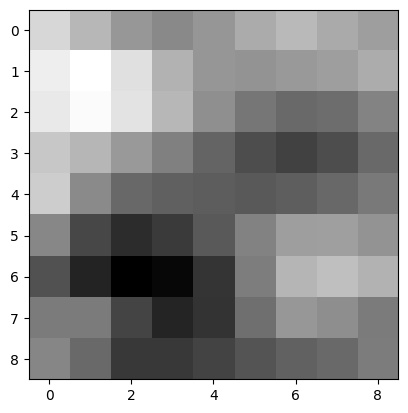

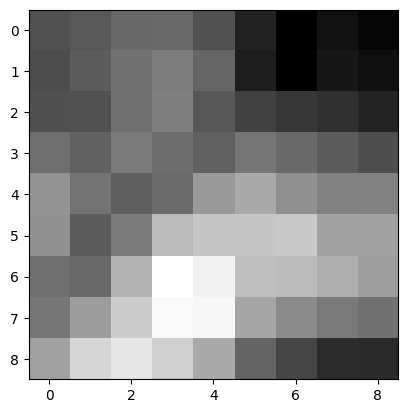

In [28]:
i = 60 
j = 60
k = 80

channel = 0

lr_patch = np.copy(subjects_lr[6][
                        i - p_size_i - e_or_o : i + p_size_i,
                        j - p_size_i - e_or_o : j + p_size_i,
                        k - p_size_i - e_or_o : k + p_size_i, :])

hr_patch = np.copy(subjects_hr[6][
                        i - p_size_o - e_or_o : i + p_size_o,
                        j - p_size_o - e_or_o : j + p_size_o,
                        k - p_size_o - e_or_o : k + p_size_o, :])

lr_mask = subjects_masks[6][
                            i - p_size_i - e_or_o : i + p_size_i,
                            j - p_size_i - e_or_o : j + p_size_i,
                            k - p_size_i - e_or_o : k + p_size_i]

lr_patch[lr_mask == 0] = 0

generated_image = generator(lr_patch[None,...], training=False)

print(discriminator(generated_image))

print(discriminator(hr_patch[None,...]))

plt.imshow(generated_image[0,:,:,3,channel],cmap='gray')
plt.figure()
plt.imshow(hr_patch[:,:,3,channel],cmap='gray')

In [29]:
# subjects_lr
# subjects_hr
# subjects_masks

result_image = np.zeros(hires_output.shape)

for (i, j, k) in tqdm(sel_indices[np.where(sel_indices[:,0]==6),1:].squeeze()):

    lr_patch = np.copy(subjects_lr[6][
                            i - p_size_i - e_or_o : i + p_size_i,
                            j - p_size_i - e_or_o : j + p_size_i,
                            k - p_size_i - e_or_o : k + p_size_i, :])

    lr_mask = subjects_masks[6][
                                i - p_size_i - e_or_o : i + p_size_i,
                                j - p_size_i - e_or_o : j + p_size_i,
                                k - p_size_i - e_or_o : k + p_size_i]

    lr_patch[lr_mask == 0] = 0

    generated_image = generator(lr_patch[None,...], training=False)

    result_image[i - p_size_o - e_or_o : i + p_size_o,
                 j - p_size_o - e_or_o : j + p_size_o,
                 k - p_size_o - e_or_o : k + p_size_o, :] = generated_image

result_image[subjects_masks[6] == 0] = 0
    

100%|██████████████████████████████████████| 1319/1319 [00:03<00:00, 390.78it/s]


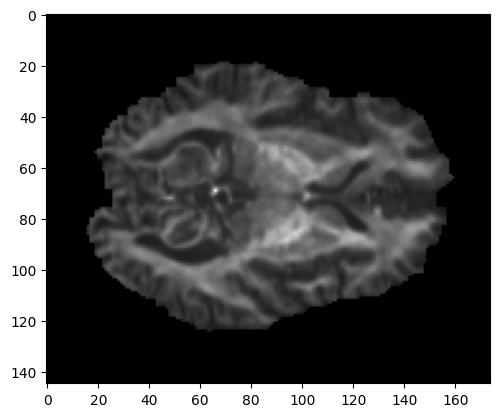

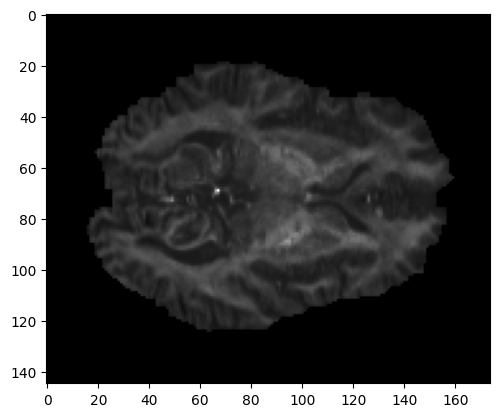

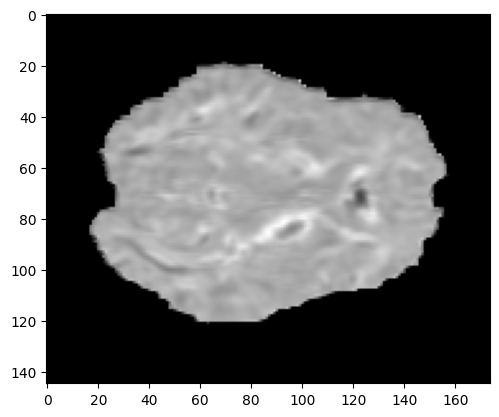

In [32]:
zdim = 60
channel = 1

# plt.imshow(subjects_masks[6][:,:,zdim], cmap='gray')
# plt.figure()
plt.imshow(subjects_lr[6][:,:,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(subjects_hr[6][:,:,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(result_image[:,:,zdim,channel], cmap='gray')
# plt.imshow((result_image[:,:,zdim,channel])*subjects_masks[6][:,:,zdim], cmap='gray')

0.061142137833722646 0.0023304373441755347 0.08048196136951447


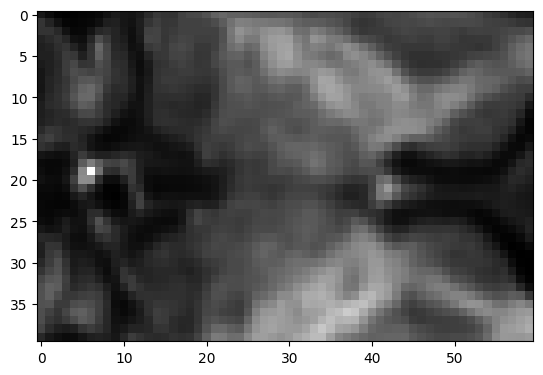

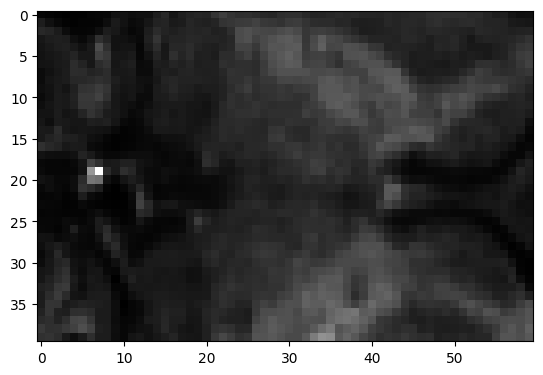

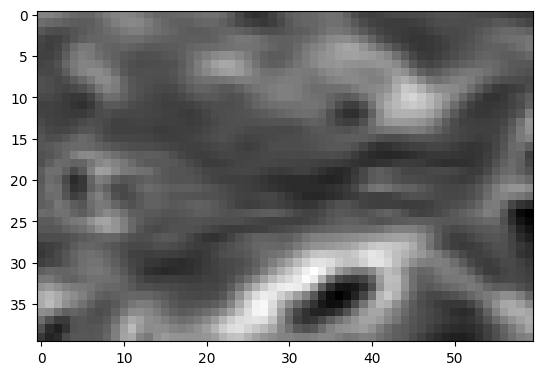

In [33]:
plt.imshow(subjects_lr[6][50:90,60:120,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(subjects_hr[6][50:90,60:120,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(result_image[50:90,60:120,zdim,channel], cmap='gray')

print(np.min(subjects_lr[6][40:80,60:120,zdim,channel]), np.min(subjects_hr[6][40:80,60:120,zdim,channel]), np.min(result_image[40:80,60:120,zdim,channel]))

In [ ]:
# generator.save_weights('Model/gen_weights')
# discriminator.save_weights('Model/disc_weights')

In [ ]:
generator.save('Model/generator{}x_map_norm'.format(2*p_size_o + e_or_o))
discriminator.save('Model/discriminator{}x_map_norm'.format(2*p_size_o + e_or_o))